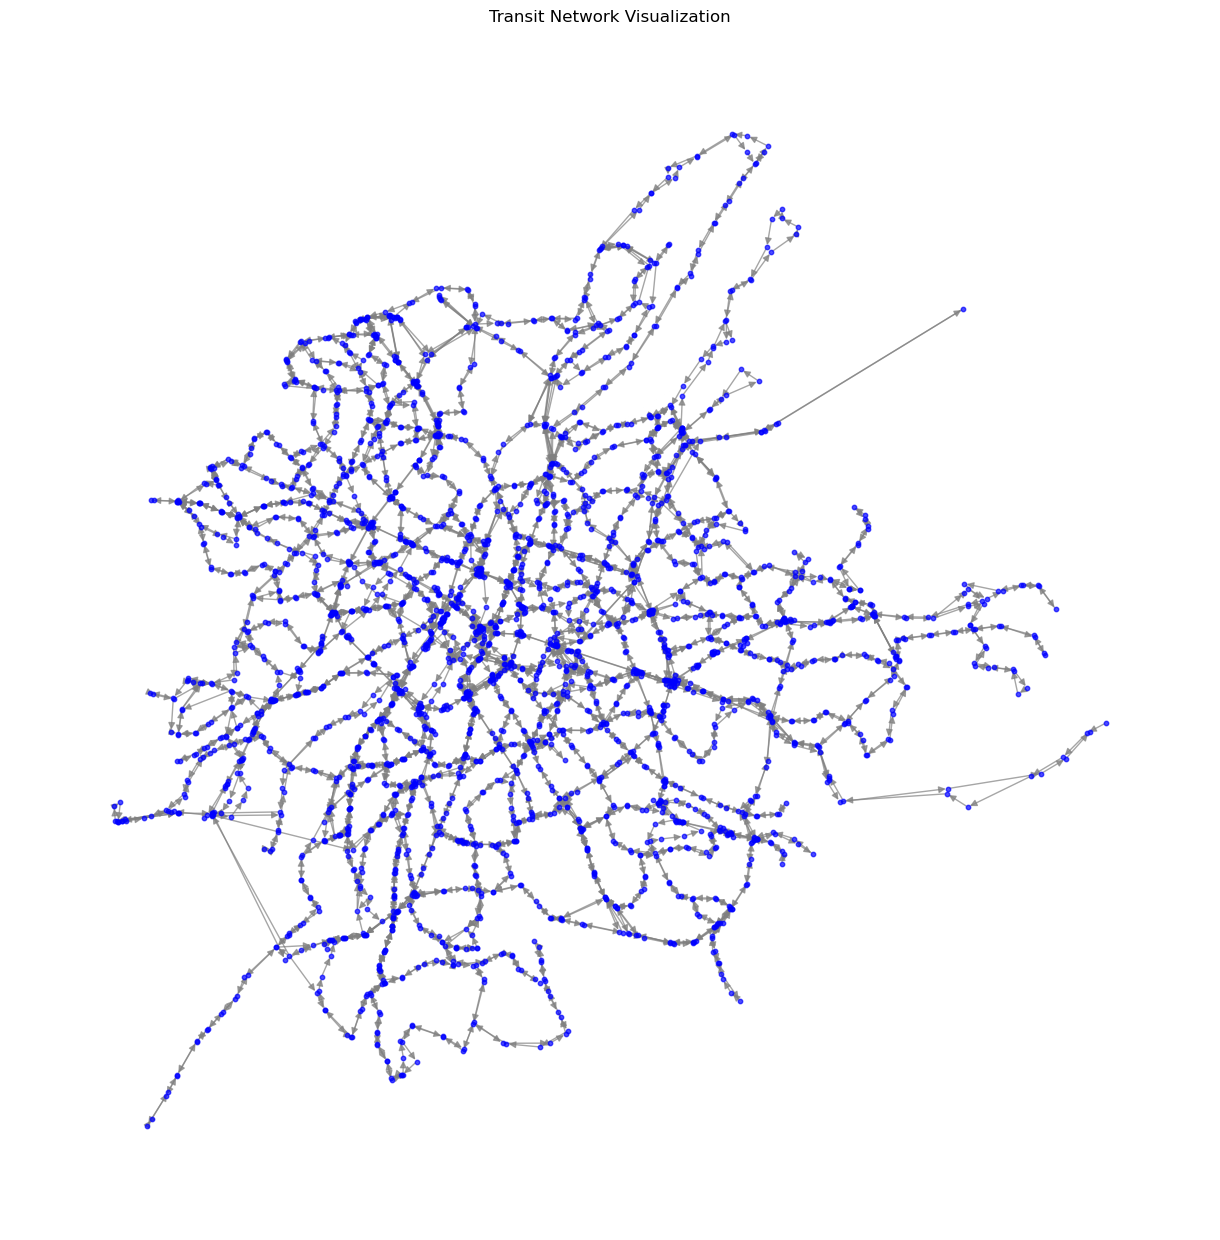

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load the necessary GTFS files
#stops_path = os.path.join(main_dir, 'stops.txt')
#stop_times_path = os.path.join(main_dir, 'stop_times.txt')
#trips_path = os.path.join(main_dir, 'trips.txt')

stops_df = pd.read_csv("stops.txt")
stop_times_df = pd.read_csv("stop_times.txt")
trips_df = pd.read_csv("trips.txt")

# Merge stop_times with stops to get stop details
stop_times_with_stops = stop_times_df.merge(stops_df, on="stop_id")

# Build the graph
G = nx.DiGraph()

# Add nodes (stops)
for _, stop in stops_df.iterrows():
    G.add_node(
        stop["stop_id"],
        name=stop["stop_name"],
        lat=stop["stop_lat"],
        lon=stop["stop_lon"],
    )

# Add edges (connections based on stop sequence)
for trip_id, trip_data in stop_times_with_stops.groupby("trip_id"):
    trip_data = trip_data.sort_values("stop_sequence")
    for i in range(len(trip_data) - 1):
        stop_a = trip_data.iloc[i]
        stop_b = trip_data.iloc[i + 1]
        G.add_edge(
            stop_a["stop_id"],
            stop_b["stop_id"],
            trip_id=trip_id,
        )

# Visualize the graph
plt.figure(figsize=(12, 12))
pos = {node: (data["lon"], data["lat"]) for node, data in G.nodes(data=True)}
nx.draw(
    G,
    pos,
    node_size=10,
    node_color="blue",
    edge_color="gray",
    with_labels=False,
    alpha=0.7,
)
plt.title("Transit Network Visualization")
plt.show()


The nodes represent transit stops, and the edges represent connections between stops based on trips and their stop sequences.

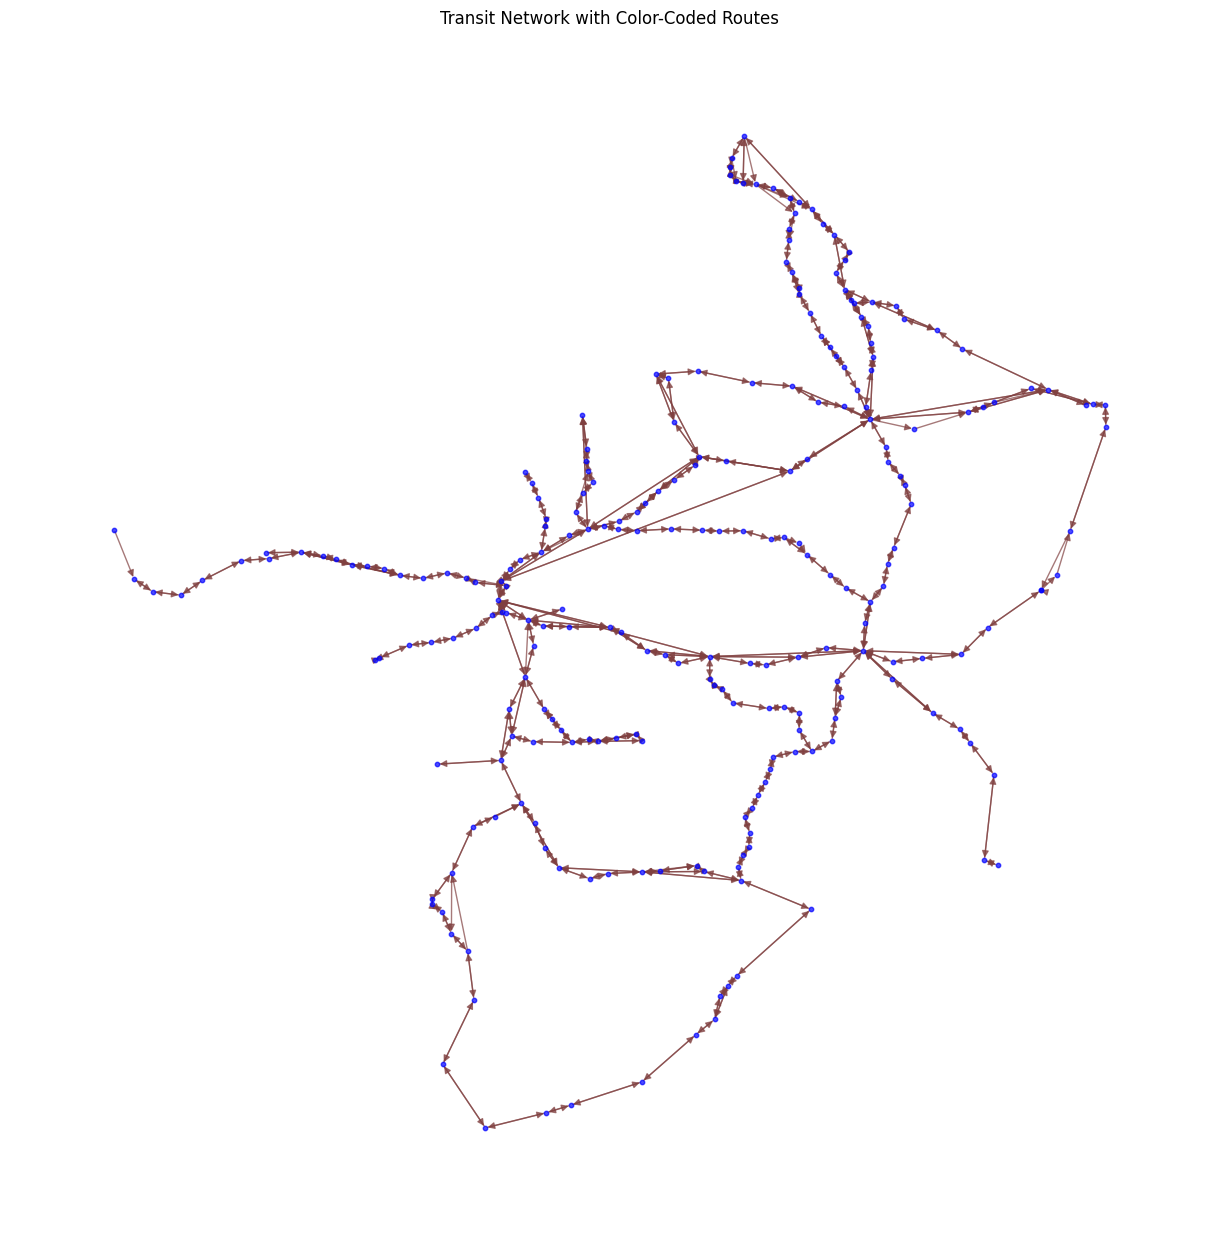

In [2]:
# Load routes.txt
#routes_path = os.path.join(main_dir, 'routes.txt')
routes_df = pd.read_csv("routes.txt")

# Merge routes with trips and stop_times to assign routes to edges
stop_times_with_routes = (
    stop_times_df
    .merge(trips_df, on="trip_id")
    .merge(routes_df, on="route_id")
)

# Add route information as edge attributes
for trip_id, trip_data in stop_times_with_routes.groupby("trip_id"):
    trip_data = trip_data.sort_values("stop_sequence")
    for i in range(len(trip_data) - 1):
        stop_a = trip_data.iloc[i]
        stop_b = trip_data.iloc[i + 1]
        G.add_edge(
            stop_a["stop_id"],
            stop_b["stop_id"],
            route_id=stop_a["route_id"],
            route_name=stop_a["route_long_name"],
            route_color=f"#{stop_a['route_color']}"
            if not pd.isnull(stop_a["route_color"])
            else "gray",
        )

# Extract edge colors based on routes
edge_colors = [
    G[u][v].get("route_color", "gray")
    for u, v in G.edges()
]

# Visualize the graph with color-coded routes
plt.figure(figsize=(12, 12))
nx.draw(
    G,
    pos,
    node_size=10,
    node_color="blue",
    edge_color=edge_colors,
    with_labels=False,
    alpha=0.7,
)
plt.title("Transit Network with Color-Coded Routes")
plt.show()


The transit network graph now includes color-coded edges based on the route information from the GTFS dataset. Each edge represents a connection between stops, and its color corresponds to the associated transit route.

 Service Frequency Map

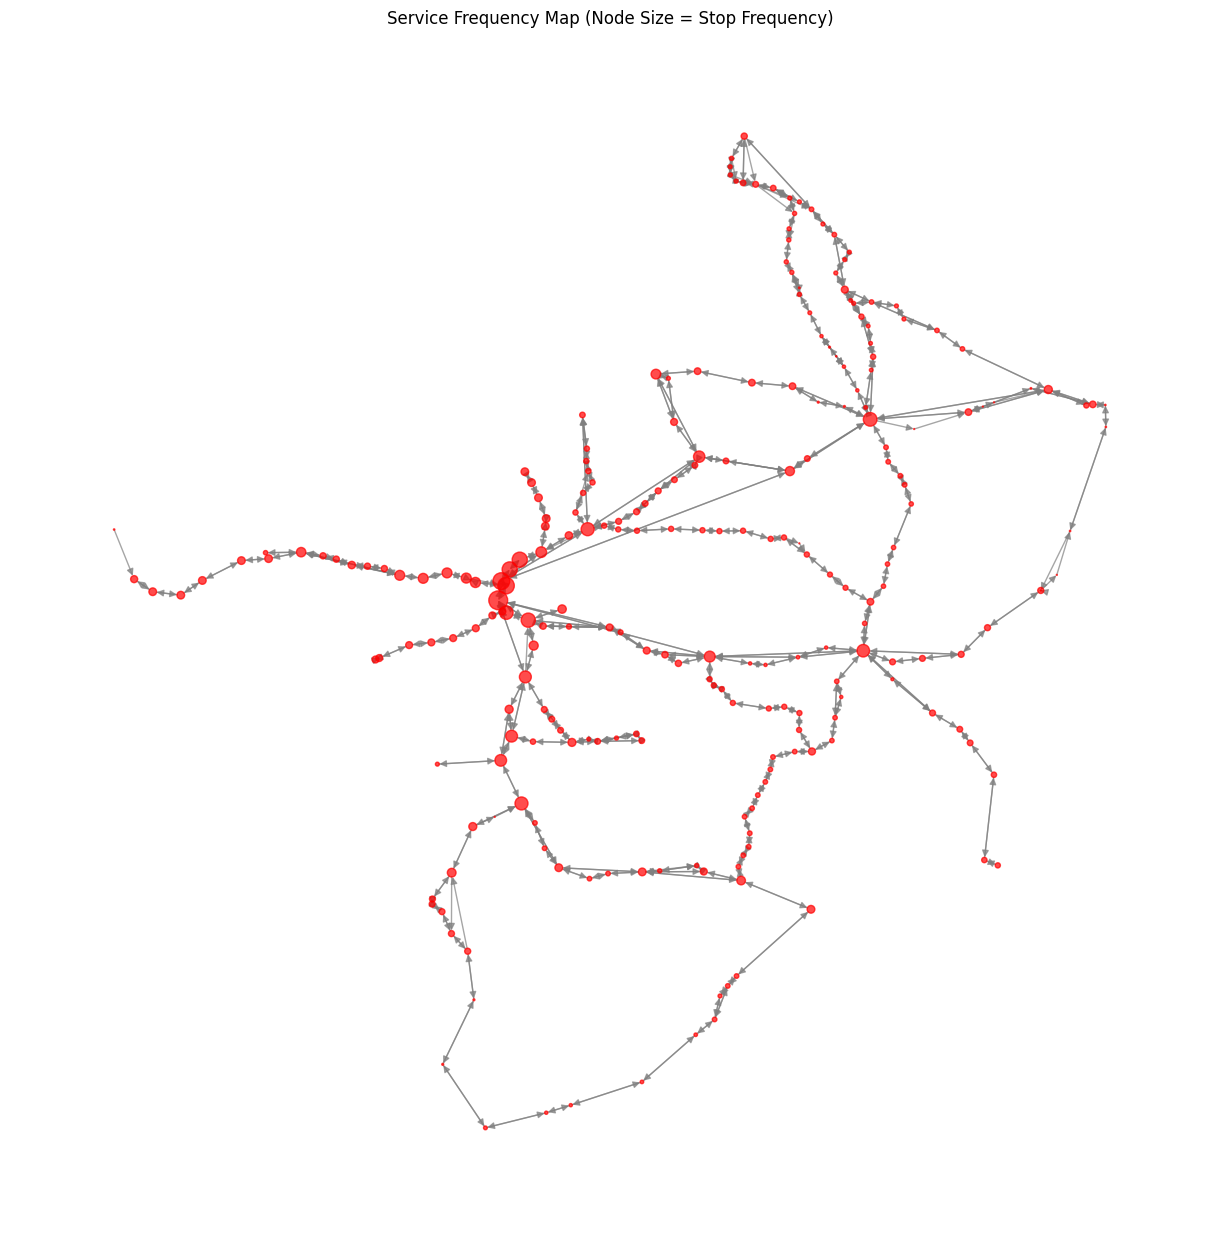

In [3]:
# Calculate stop frequency from stop_times.txt
stop_frequencies = stop_times_df["stop_id"].value_counts().reset_index()
stop_frequencies.columns = ["stop_id", "frequency"]

# Merge frequencies with stop locations
stops_with_frequencies = stops_df.merge(stop_frequencies, on="stop_id")

# Visualize frequency map using node size proportional to frequency
plt.figure(figsize=(12, 12))
pos = {stop["stop_id"]: (stop["stop_lon"], stop["stop_lat"]) for _, stop in stops_with_frequencies.iterrows()}
node_sizes = [freq * 0.5 for freq in stops_with_frequencies["frequency"]]

nx.draw(
    G,
    pos,
    node_size=node_sizes,
    node_color="red",
    edge_color="gray",
    with_labels=False,
    alpha=0.7,
)
plt.title("Service Frequency Map (Node Size = Stop Frequency)")
plt.show()


The Service Frequency Map is displayed, where the node size represents the frequency of services stopping at each location. Larger nodes indicate stops with more services.

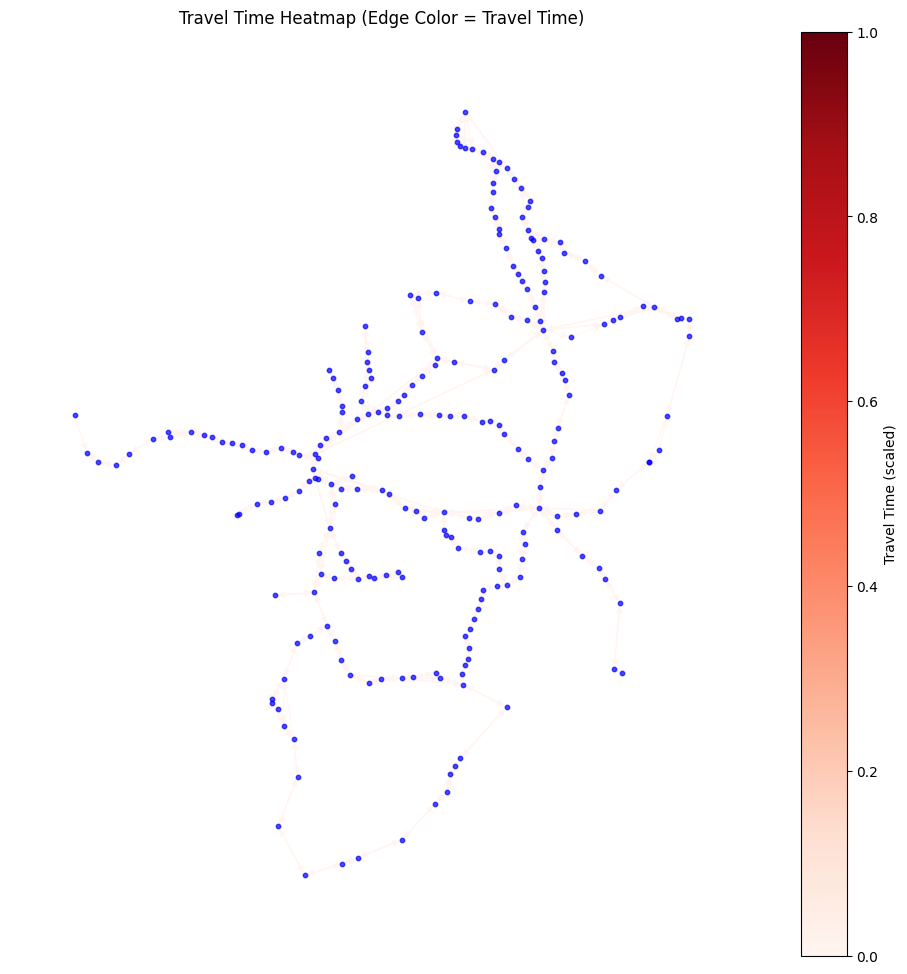

In [4]:
# Calculate travel times between consecutive stops
stop_times_with_stops_sorted = stop_times_with_stops.sort_values(["trip_id", "stop_sequence"])
stop_times_with_stops_sorted["travel_time"] = pd.to_datetime(
    stop_times_with_stops_sorted["arrival_time"], format="%H:%M:%S", errors="coerce"
) - pd.to_datetime(
    stop_times_with_stops_sorted["departure_time"], format="%H:%M:%S", errors="coerce"
)

# Filter valid travel times
stop_times_with_stops_sorted["travel_time"] = stop_times_with_stops_sorted["travel_time"].dt.total_seconds()
valid_edges = stop_times_with_stops_sorted.dropna(subset=["travel_time"])

# Map travel times to edges in the graph
for i in range(len(valid_edges) - 1):
    stop_a = valid_edges.iloc[i]
    stop_b = valid_edges.iloc[i + 1]
    if stop_a["trip_id"] == stop_b["trip_id"]:
        G[stop_a["stop_id"]][stop_b["stop_id"]]["travel_time"] = stop_b["travel_time"]

# Visualize travel time heatmap (edge color = travel time)
edge_colors_travel_time = [
    G[u][v].get("travel_time", 0) for u, v in G.edges()
]
edge_colors_scaled = [time / max(edge_colors_travel_time) if time > 0 else 0.1 for time in edge_colors_travel_time]

plt.figure(figsize=(12, 12))
ax = plt.gca()

nx.draw(
    G,
    pos,
    node_size=10,
    node_color="blue",
    edge_color=edge_colors_scaled,
    edge_cmap=plt.cm.Reds,
    with_labels=False,
    alpha=0.7,
)
# Create a dummy mappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds)
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Travel Time (scaled)")

plt.title("Travel Time Heatmap (Edge Color = Travel Time)")
plt.show()


The Travel Time Heatmap is displayed. Edge colors represent travel times between stops, with warmer colors (red) indicating longer travel times.

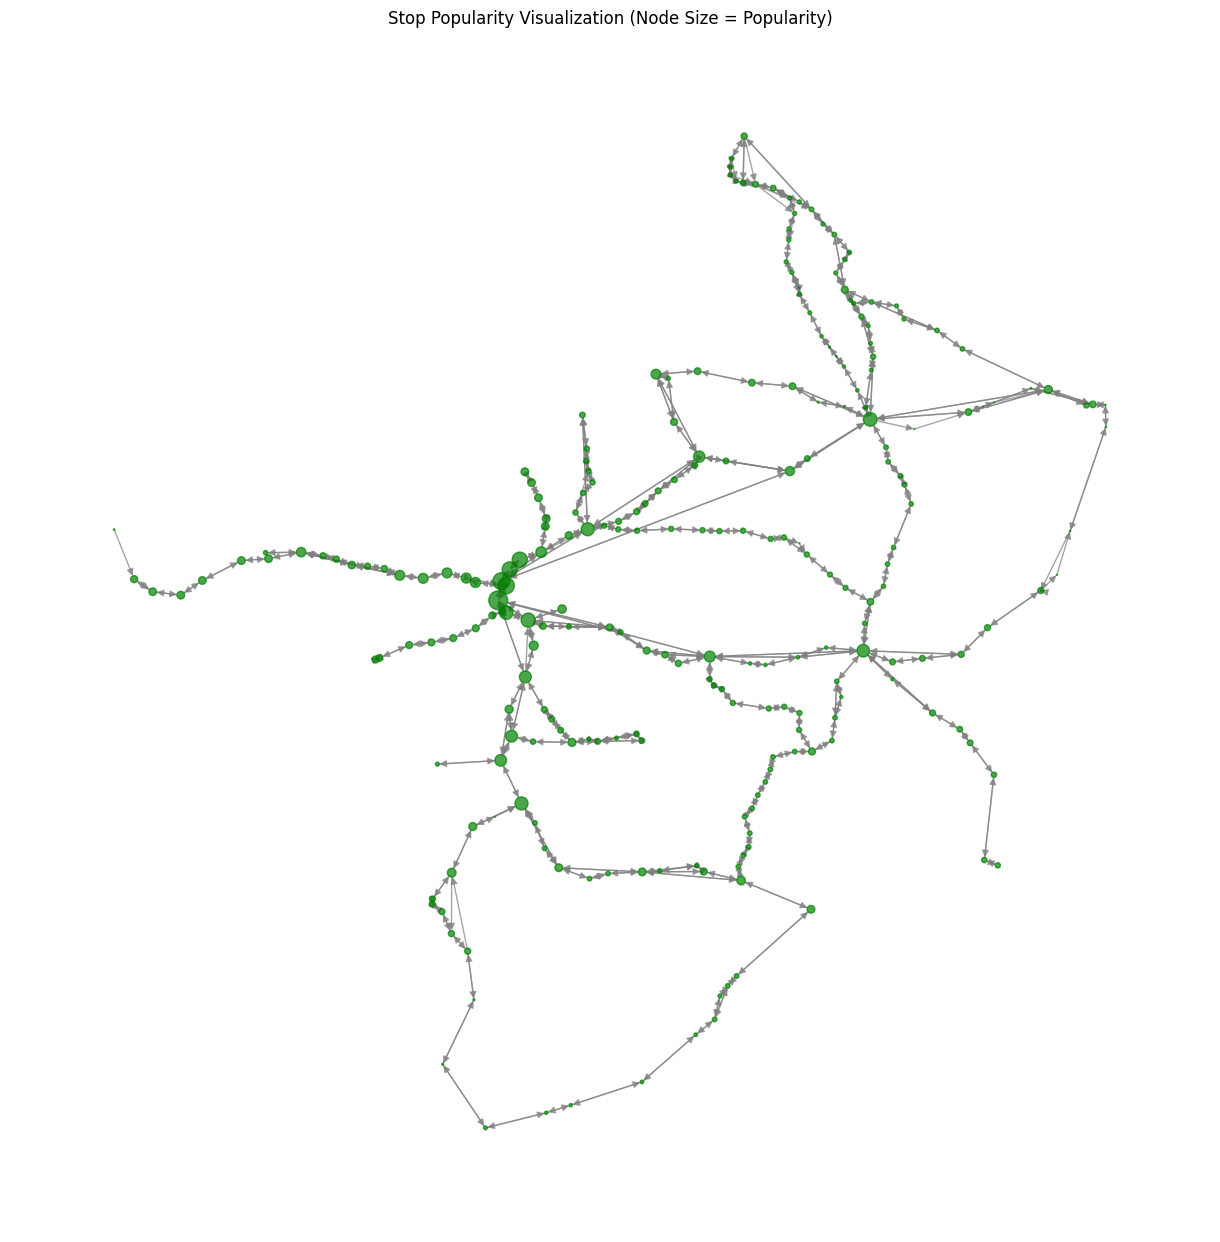

In [5]:
# Calculate stop popularity from stop_times.txt (frequency of stops)
stop_popularity = stop_times_df["stop_id"].value_counts().reset_index()
stop_popularity.columns = ["stop_id", "popularity"]

# Merge popularity with stops data
stops_with_popularity = stops_df.merge(stop_popularity, on="stop_id", how="left")
stops_with_popularity["popularity"] = stops_with_popularity["popularity"].fillna(0)

# Visualize popularity map using node size proportional to popularity
plt.figure(figsize=(12, 12))
node_sizes_popularity = [pop * 0.5 for pop in stops_with_popularity["popularity"]]
pos_popularity = {stop["stop_id"]: (stop["stop_lon"], stop["stop_lat"]) for _, stop in stops_with_popularity.iterrows()}

nx.draw(
    G,
    pos_popularity,
    node_size=node_sizes_popularity,
    node_color="green",
    edge_color="gray",
    with_labels=False,
    alpha=0.7,
)
plt.title("Stop Popularity Visualization (Node Size = Popularity)")
plt.show()


The Stop Popularity Visualization is displayed, where node sizes correspond to the frequency of stops being serviced. Larger nodes represent more popular stops with higher service frequency.

In [6]:
from networkx.algorithms.clique import find_cliques

# Convert the directed graph to an undirected graph for clique detection
G_undirected = G.to_undirected()

# Find all cliques in the network
cliques = list(find_cliques(G_undirected))

# Sort cliques by size and select the largest ones
largest_cliques = sorted(cliques, key=len, reverse=True)[:5]

# Display the largest cliques
largest_cliques_sizes = [len(clique) for clique in largest_cliques]
largest_cliques_sizes


[3, 3, 3, 3, 3]

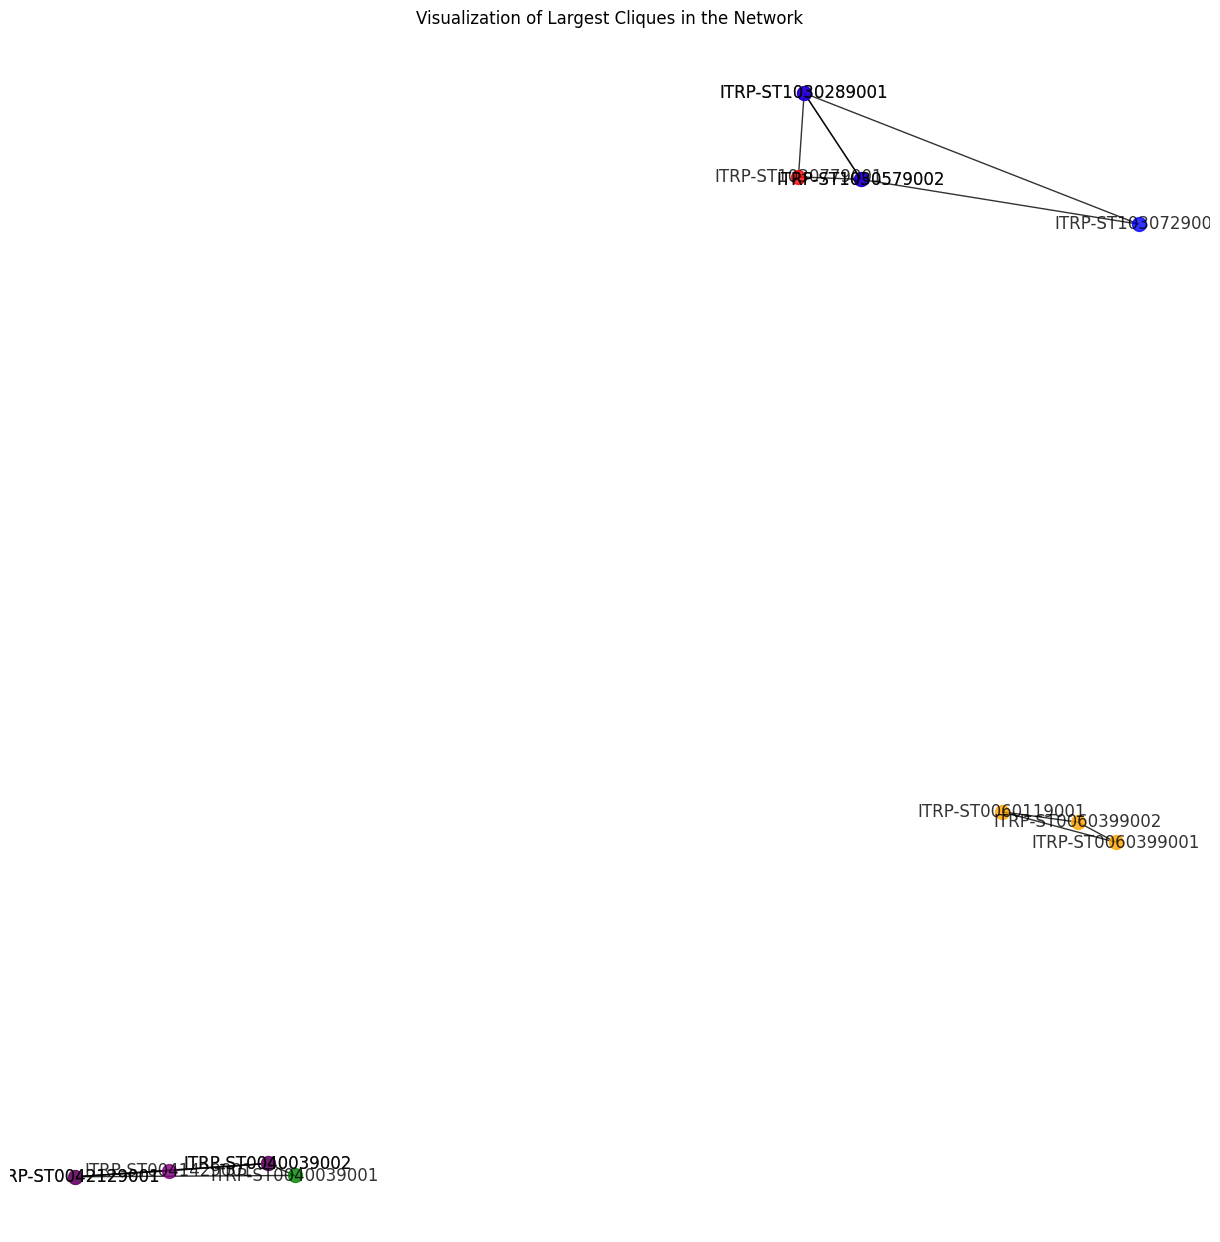

In [7]:
# Visualize the largest cliques
plt.figure(figsize=(12, 12))

# Highlight each clique in a different color
colors = ["red", "blue", "green", "purple", "orange"]
for idx, clique in enumerate(largest_cliques):
    subgraph = G_undirected.subgraph(clique)
    nx.draw(
        subgraph,
        pos,
        node_size=100,
        node_color=colors[idx % len(colors)],
        with_labels=True if len(clique) <= 5 else False,  # Show labels for smaller cliques
        alpha=0.8,
    )

plt.title("Visualization of Largest Cliques in the Network")
plt.show()
